In [1]:
from fastai.imports import *
from fastai.torch_imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [2]:
torch.cuda.set_device(0)

# Densenet 161

In [3]:
PATH = 'flower_data/'
sz = 224
arch = dn161
bs = 64
mcs = arch(True)

In [4]:
mcs

Sequential(
  (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True)
  (relu0): ReLU(inplace)
  (pool0): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1), ceil_mode=False)
  (denseblock1): _DenseBlock(
    (denselayer1): _DenseLayer(
      (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True)
      (relu1): ReLU(inplace)
      (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True)
      (relu2): ReLU(inplace)
      (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (denselayer2): _DenseLayer(
      (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True)
      (relu1): ReLU(inplace)
      (conv1): Conv2d(144, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, 

In [5]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)
      
class ClassifierH2(nn.Module):
    def __init__(self, inp = 2208, h1=1024, h2=1024, out = 102, d=0.35):
        super().__init__()
        self.ap = nn.AdaptiveAvgPool2d((1,1))
        self.mp = nn.AdaptiveMaxPool2d((1,1))
        
        self.fla = Flatten()
        self.bn0 = nn.BatchNorm1d(inp*2,eps=1e-05, momentum=0.1, affine=True)
        self.dropout0 = nn.Dropout(d)
        self.fc1 = nn.Linear(inp*2, h2)
        self.bn1 = nn.BatchNorm1d(h2,eps=1e-05, momentum=0.1, affine=True)
        self.dropout1 = nn.Dropout(d)

        self.fc3 = nn.Linear(h2, out)
        
    def forward(self, x):
        ap = self.ap(x)
        mp = self.mp(x)
        x = torch.cat((ap,mp),dim=1)
        x = self.fla(x)
        x = self.bn0(x)
        x = self.dropout0(x)
        x = F.relu(self.fc1(x))
        x = self.bn1(x)
        x = self.dropout1(x)         
        x = self.fc3(x)
        
        return x

In [6]:
mcs = nn.Sequential(*children(mcs),ClassifierH2(),nn.LogSoftmax(dim=1))

In [7]:
augs = [
    RandomFlip(),
    RandomLighting(0.05, 0.05),
    RandomRotate(30)
    ]

In [8]:
tfms = tfms_from_model(arch, sz, aug_tfms=augs, max_zoom=1.1)
data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=bs, num_workers=4)

In [9]:
learn = ConvLearner.from_model_data(mcs, data)

In [10]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 224, 224]),
                           ('output_shape', [-1, 96, 112, 112]),
                           ('trainable', True),
                           ('nb_params', 14112)])),
             ('BatchNorm2d-2',
              OrderedDict([('input_shape', [-1, 96, 112, 112]),
                           ('output_shape', [-1, 96, 112, 112]),
                           ('trainable', True),
                           ('nb_params', 192)])),
             ('ReLU-3',
              OrderedDict([('input_shape', [-1, 96, 112, 112]),
                           ('output_shape', [-1, 96, 112, 112]),
                           ('nb_params', 0)])),
             ('MaxPool2d-4',
              OrderedDict([('input_shape', [-1, 96, 112, 112]),
                           ('output_shape', [-1, 96, 56, 56]),
                           ('nb_params', 0)])),
             ('BatchNorm2d-5',
              OrderedDict([('input_shape', [-1, 96, 

In [11]:
len(learn.get_layer_groups())

14

In [12]:
learn.freeze_to(-2)

In [13]:
learn.lr_find()

 95%|█████████▌| 98/103 [02:17<00:07,  1.40s/it, loss=17.8]

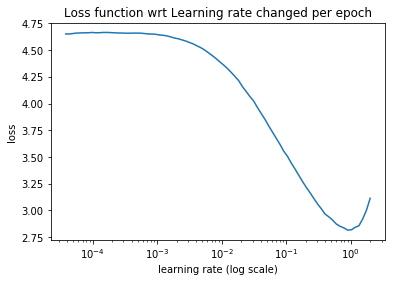

In [14]:
plt.title('Loss function wrt Learning rate changed per epoch')
learn.sched.plot()

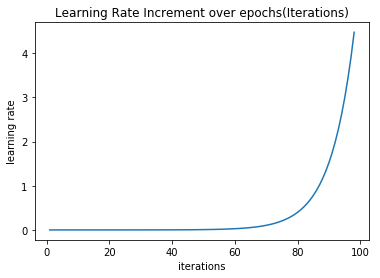

In [15]:
plt.title('Learning Rate Increment over epochs(Iterations)')
learn.sched.plot_lr()

In [16]:
learn.fit(2e-2, 1)

epoch      trn_loss   val_loss   accuracy                   
    0      1.037588   0.403141   0.92665   


[array([0.40314]), 0.92665036529084]

In [17]:
learn.fit(2e-2, 3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                    
    0      0.362927   0.295973   0.940098  
    1      0.269939   0.248088   0.949878                    
    2      0.224835   0.212618   0.952323                    


[array([0.21262]), 0.9523227395521691]

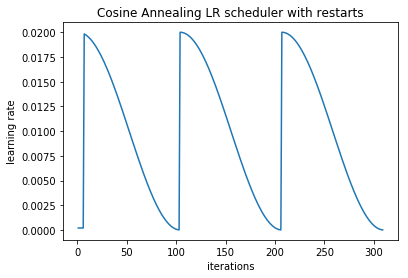

In [18]:
plt.title('Cosine Annealing LR scheduler with restarts')
learn.sched.plot_lr()

In [19]:
learn.fit(2e-2, 3, cycle_len=1,cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                    
    0      0.180027   0.203026   0.9511    
    1      0.168181   0.1838     0.95599                     
    2      0.133991   0.183144   0.95599                     
    3      0.13144    0.173315   0.95599                     
    4      0.101157   0.164079   0.959658                     
    5      0.089617   0.159789   0.959658                     
    6      0.078108   0.157115   0.959658                     


[array([0.15712]), 0.9596577028773524]

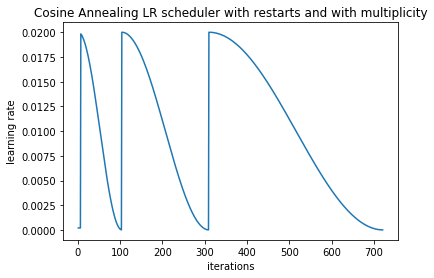

In [20]:
plt.title('Cosine Annealing LR scheduler with restarts and with multiplicity')
learn.sched.plot_lr()

In [21]:
learn.freeze_to(-4)

In [22]:
learn.lr_find()

 82%|████████▏ | 84/103 [02:04<00:29,  1.55s/it, loss=0.76] 

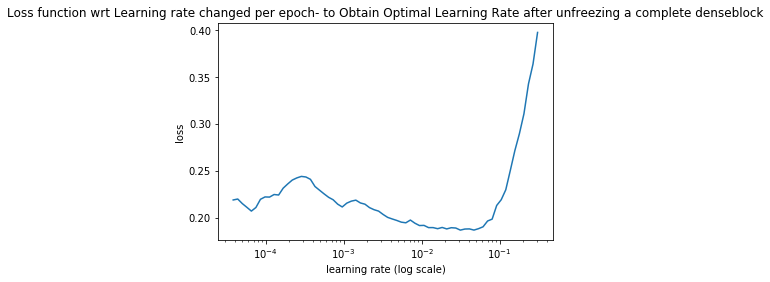

In [23]:
plt.title('Loss function wrt Learning rate changed per epoch- to Obtain Optimal Learning Rate after unfreezing a complete denseblock')
learn.sched.plot()

### Repeat the above procedure till you get 99% accuracy and also using certain techniques from [here](https://github.com/masterflorin/PyTorchChallengeScholarship2018-19/blob/master/fine_tuning/fine_tuning.md)